In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

2024-08-15 18:47:12.987334: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-15 18:47:13.314563: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 18:47:14.187832: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df_final = pd.read_csv('/mnt/d/Magister Program/Master Computer Science/Semester 2/Big Data/BigData_project/02-traffic-weather.csv')

In [3]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22406 entries, 0 to 22405
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          22406 non-null  object 
 1   meridiem      22406 non-null  object 
 2   roadway name  22406 non-null  object 
 3   volume        22406 non-null  float64
 4   precip type   22406 non-null  object 
 5   temperature   22406 non-null  float64
 6   humidity      22406 non-null  float64
 7   wind speed    22406 non-null  float64
dtypes: float64(4), object(4)
memory usage: 1.4+ MB


In [4]:
df_final.head()

,date,meridiem,roadway name,volume,precip type,temperature,humidity,wind speed
0,2012-01-08,AM,3 AVE,105.645833,rain,1.495833,0.9125,9.975292
1,2012-01-08,PM,3 AVE,204.750000,rain,2.766204,0.9300,7.997675
2,2012-01-08,AM,FULTON AVENUE,176.250000,rain,1.495833,0.9125,9.975292
3,2012-01-08,PM,FULTON AVENUE,244.458333,rain,2.766204,0.9300,7.997675
4,2012-01-08,AM,VAN BRUNT ST,45.166667,rain,1.495833,0.9125,9.975292


## Regression Modelling

In [5]:
df_final.set_index('date', inplace=True)
df_final.head()

,meridiem,roadway name,volume,precip type,temperature,humidity,wind speed
date,,,,,,,
2012-01-08,AM,3 AVE,105.645833,rain,1.495833,0.9125,9.975292
2012-01-08,PM,3 AVE,204.750000,rain,2.766204,0.9300,7.997675
2012-01-08,AM,FULTON AVENUE,176.250000,rain,1.495833,0.9125,9.975292
2012-01-08,PM,FULTON AVENUE,244.458333,rain,2.766204,0.9300,7.997675
2012-01-08,AM,VAN BRUNT ST,45.166667,rain,1.495833,0.9125,9.975292


In [6]:
df_final.tail()

,meridiem,roadway name,volume,precip type,temperature,humidity,wind speed
date,,,,,,,
2016-12-02,PM,FLUSHING AVENUE,347.666667,rain,3.886111,0.845000,11.424292
2016-12-03,AM,FLUSHING AVENUE,235.291667,rain,1.404630,0.913333,10.694425
2016-12-03,PM,FLUSHING AVENUE,334.750000,rain,3.749074,0.847500,11.469908
2016-12-04,AM,FLUSHING AVENUE,213.750000,rain,1.282407,0.914167,10.690400
2016-12-04,PM,FLUSHING AVENUE,288.000000,rain,3.614815,0.847500,11.492717


In [7]:
df_lstm = df_final.copy()
df_lstm.drop(columns=['meridiem', 'roadway name', 'precip type', 'temperature',
                     'humidity', 'wind speed'],
              axis=1, inplace=True)

# Scaling the 'volume' column
scaler = StandardScaler()
df_lstm['volume'] = scaler.fit_transform(df_lstm[['volume']])

# Splitting data into training and testing sets
train_size = int(len(df_lstm) * 0.8)
test_size = len(df_lstm) - train_size
train, test = df_lstm.iloc[0:train_size], df_lstm.iloc[train_size:len(df_lstm)]

# Creating time series generators
sequence_length = 12  # Number of time steps to look back
batch_size = 32

train_generator = TimeseriesGenerator(train['volume'], train['volume'], length=sequence_length, batch_size=batch_size)
test_generator = TimeseriesGenerator(test['volume'], test['volume'], length=sequence_length, batch_size=batch_size)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17924 entries, 2012-01-08 to 2015-10-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   volume  17924 non-null  float64
dtypes: float64(1)
memory usage: 280.1+ KB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4482 entries, 2015-10-31 to 2016-12-04
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   volume  4482 non-null   float64
dtypes: float64(1)
memory usage: 70.0+ KB


In [10]:
df_lstm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22406 entries, 2012-01-08 to 2016-12-04
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   volume  22406 non-null  float64
dtypes: float64(1)
memory usage: 350.1+ KB


2024-08-15 18:47:17.903905: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-15 18:47:17.904350: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/hasnan_mr/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/hasnan_mr/miniconda3/envs/tf/lib/python3.11/site-packages

Epoch 1/100
 39/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8330

/home/hasnan_mr/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


560/560 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.7375 - val_loss: 1.4503
Epoch 2/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6688 - val_loss: 1.3709
Epoch 3/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6993 - val_loss: 1.3237
Epoch 4/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6546 - val_loss: 1.2758
Epoch 5/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6529 - val_loss: 1.2458
Epoch 6/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6680 - val_loss: 1.2267
Epoch 7/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5419 - val_loss: 1.1694
Epoch 8/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6152 - val_loss: 1.1788
Epoch 9/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6286 - val_loss: 1.1624
Epoch 10/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5655 - val_loss: 1.1350
Epoch 11/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5536 - val_loss: 1.1272
Epoch 12/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

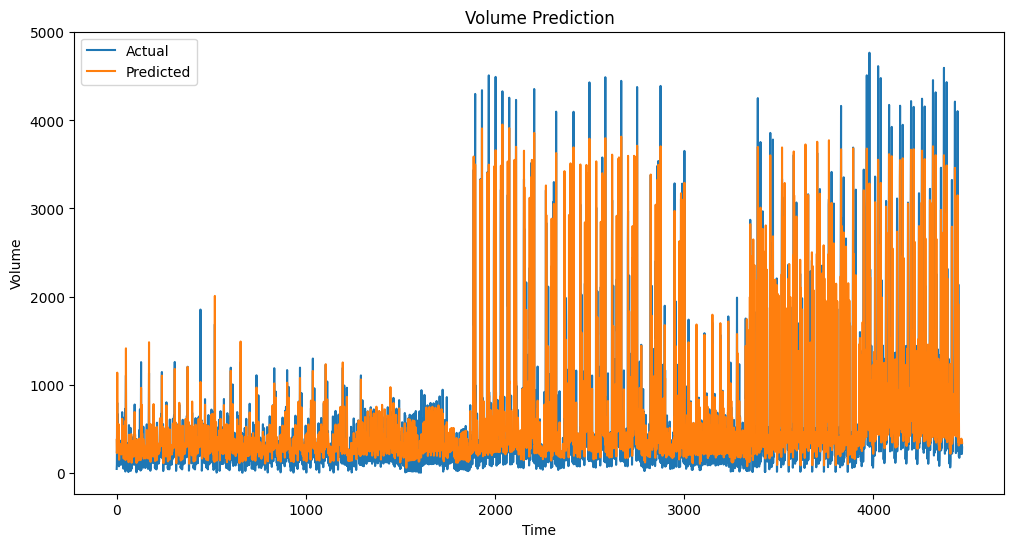

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

# Building the LSTM model
model = Sequential()
model.add(LSTM(25, activation='tanh', return_sequences=False, input_shape=(sequence_length, 1)))
model.add(Dropout(0.25))
# model.add(LSTM(10, activation='tanh'))
# model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer=optimizer, loss='mse')

# Adding EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the LSTM model with early stopping
history = model.fit(train_generator, epochs=100, validation_data=test_generator, callbacks=[early_stopping], verbose=1)

# Making predictions
predictions = model.predict(test_generator)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(test[sequence_length:].values)

# Creating a DataFrame to compare predictions and actual values
pred_df = pd.DataFrame({'Actual': actual.flatten(), 'Predicted': predictions.flatten()})


plt.figure(figsize=(12, 6))
plt.plot(pred_df['Actual'], label='Actual')
plt.plot(pred_df['Predicted'], label='Predicted')
plt.title('Volume Prediction')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import r2_score, mean_squared_error

# Calculate R² score and MSE
r2 = r2_score(actual, predictions)
mse = mean_squared_error(actual, predictions)

print(f'R² Score: {r2}')
print(f'Mean Squared Error: {mse}')

R² Score: 0.6727554251019507
Mean Squared Error: 180557.87955208722


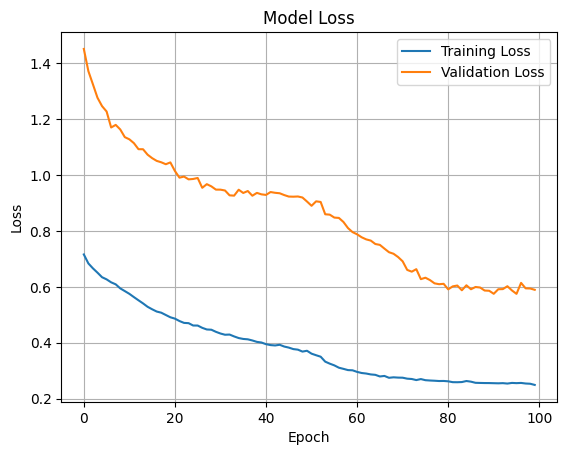

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()